# Implementation of MBGWO and Random Forest on Sampled CICIDS2017 Dataset

This notebook presents the implementation of a Modified Binary Grey Wolf Optimizer (MBGWO) for feature selection in the context of an Intrusion Detection System (IDS).

We evaluate and compare the performance of multiple machine learning classifiers—including Random Forest, Decision Tree, XGBoost, and Extra Trees—before and after applying MBGWO-based feature selection. The dataset used is a sampled version of the CICIDS2017 dataset, which represents realistic network traffic with various attack vectors.

The core objectives of this notebook are:
- To apply MBGWO for selecting the most relevant features from high-dimensional intrusion data.
- To compare classifier performance using the full feature set vs. the MBGWO-optimized feature subset.
- To visualize evaluation metrics including Accuracy, Precision, Recall, F1-score, AUC-ROC, and Confusion Matrices.

This implementation demonstrates how nature-inspired metaheuristic optimization (MBGWO) can enhance the accuracy and efficiency of intrusion detection models by reducing feature dimensionality while maintaining classification performance.



=== Random Forest (All Features) ===
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      3645
           1       0.98      0.99      0.98       393
           2       1.00      0.89      0.94        19
           3       0.99      0.99      0.99       609
           4       1.00      0.86      0.92         7
           5       0.99      1.00      0.99       251
           6       1.00      0.97      0.99       436

    accuracy                           0.99      5360
   macro avg       0.99      0.96      0.97      5360
weighted avg       0.99      0.99      0.99      5360

{'Accuracy': 0.9916044776119403, 'Precision': 0.9916306045282003, 'Recall': 0.9916044776119403, 'F1': 0.9915846724789242, 'AUC': 0.9991975895585877}


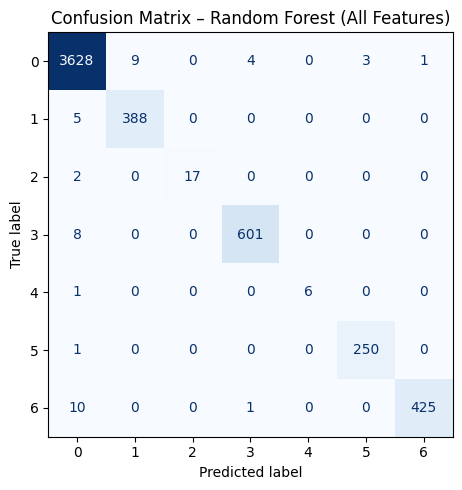

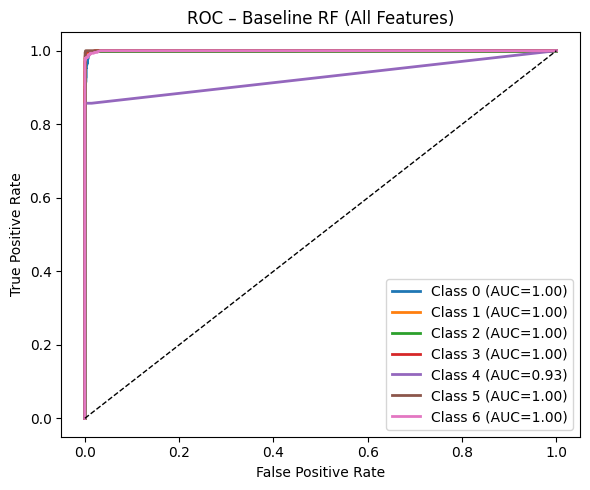

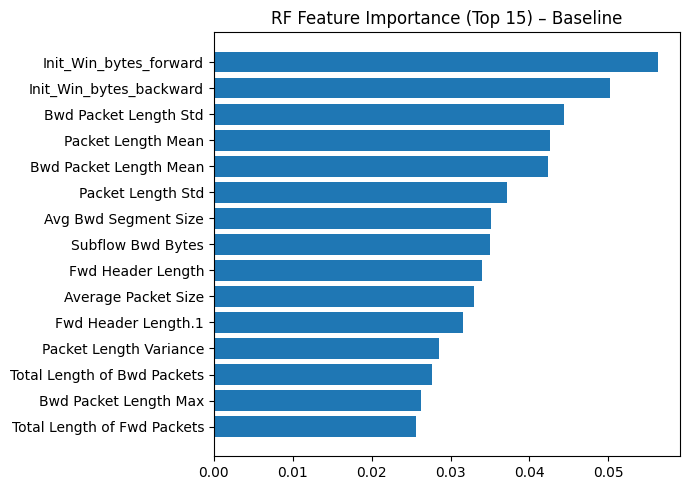

2025/08/31 07:36:43 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: OriginalGWO(epoch=20, pop_size=50)


Running MBGWO: epoch=20, pop_size=50, alpha=0.99


2025/08/31 07:38:20 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: FS-IDS, Epoch: 1, Current best: 0.9887388550729426, Global best: 0.9887388550729426, Runtime: 0.04670 seconds
2025/08/31 07:38:20 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: FS-IDS, Epoch: 2, Current best: 0.9887388550729426, Global best: 0.9887388550729426, Runtime: 0.05577 seconds
2025/08/31 07:38:20 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: FS-IDS, Epoch: 3, Current best: 0.9887388550729426, Global best: 0.9887388550729426, Runtime: 0.05572 seconds
2025/08/31 07:38:21 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: FS-IDS, Epoch: 4, Current best: 0.9887388550729426, Global best: 0.9887388550729426, Runtime: 0.06380 seconds
2025/08/31 07:38:21 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: FS-IDS, Epoch: 5, Current best: 0.9887388550729426, Global best: 0.9887388550729426, Runtime: 0.07756 seconds
2025/08/31 07:38:21 PM, INFO, mealpy.swarm_based.GWO.Origina

✅ MBGWO Finished!
Best Fitness Score: id: 12701, target: Objectives: [0.99240119], Fitness: 0.9924011931411205, solution: [0.33333333 0.66666667 1.         0.         0.66666667 0.33333333
 0.66666667 0.33333333 0.         0.33333333 0.66666667 0.33333333
 0.33333333 1.         0.33333333 0.         0.66666667 0.
 0.33333333 0.66666667 0.33333333 0.33333333 0.33333333 1.
 0.33333333 0.66666667 0.         0.66666667 0.33333333 0.33333333
 0.33333333 0.66666667 0.66666667 1.         0.33333333 0.
 0.66666667 0.33333333 1.         0.         0.33333333 0.33333333
 0.         0.66666667 0.66666667 0.33333333 0.66666667 1.
 0.33333333 0.66666667 0.33333333 1.         1.         0.33333333
 0.66666667 0.33333333 0.66666667 0.66666667 0.66666667 0.33333333
 0.         0.66666667 0.66666667 1.         0.66666667 1.
 1.         0.66666667 0.66666667 1.         0.66666667 0.33333333
 0.33333333 0.66666667 1.         0.33333333 0.        ]
Number of Selected Features: 13
Selected Feature Indexes:

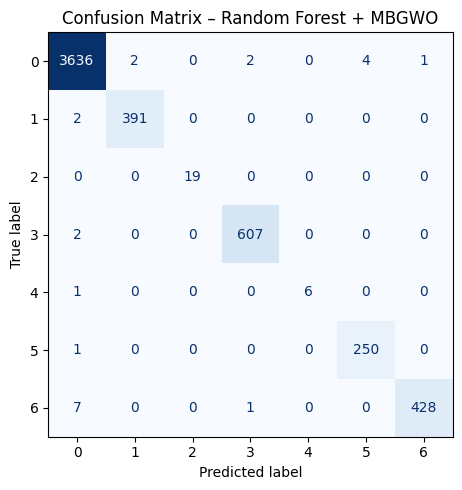

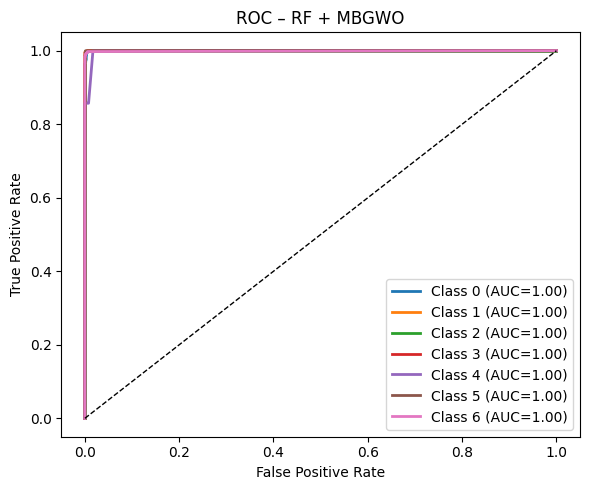

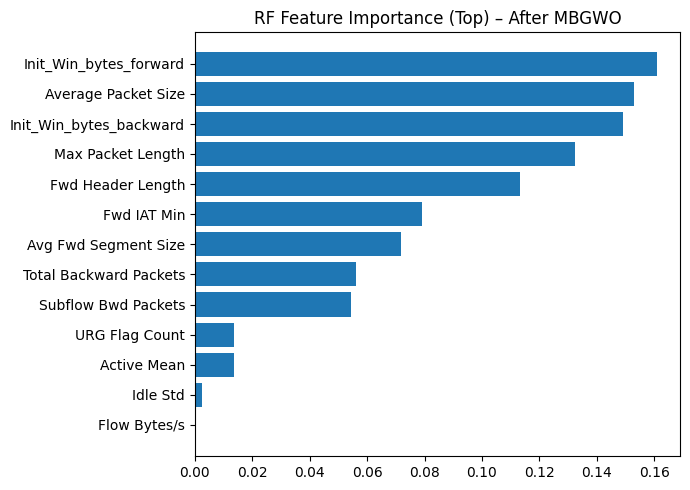


=== Comparison ===
                          Model  Accuracy  Precision    Recall        F1  \
0  Random Forest (All Features)  0.991604   0.991631  0.991604  0.991585   
1         Random Forest + MBGWO  0.995709   0.995718  0.995709  0.995699   

        AUC  
0  0.999198  
1  0.999343  


In [ ]:
# Importing Libraries

import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

# ----------------------------
# 0) CONFIG
# ----------------------------
CSV_PATH = "./data/CICIDS2017_sample.csv"    # e.g., "CICIDS2017_sample_km.csv" or None if df already exists
TARGET   = "Label"
RANDOM_SEED = 42

# MBGWO hyperparams
EPOCHS   = 20
POP_SIZE = 50
ALPHA    = 0.99   # weight on accuracy vs (1 - feature_ratio)

# ----------------------------
# 1) LOAD / PREP DATAFRAME
# ----------------------------
if "df" not in globals():
    if CSV_PATH is None:
        raise RuntimeError("Set CSV_PATH to your dataset path, or define `df` beforehand.")
    df = pd.read_csv(CSV_PATH)

# Keep only numeric + target, handle categorical target
from sklearn.preprocessing import LabelEncoder
df = df.copy()

# Clean inf/nan
df = df.replace([np.inf, -np.inf], np.nan).dropna()

# Ensure target exists
if TARGET not in df.columns:
    raise ValueError(f"TARGET '{TARGET}' not found in columns: {list(df.columns)[:10]}...")

# If target not numeric, encode to ints but preserve original labels for display
y_raw = df[TARGET]
if not np.issubdtype(df[TARGET].dtype, np.number):
    le = LabelEncoder()
    y = le.fit_transform(y_raw)
    class_names = le.classes_
else:
    y = df[TARGET].astype(int).values
    class_names = np.unique(y).astype(str)

X_df = df.drop(columns=[TARGET])
# Ensure all features are numeric
X_df = X_df.select_dtypes(include=[np.number])
feature_names = X_df.columns.to_list()
X = X_df.values

# ----------------------------
# 2) TRAIN / TEST SPLIT + SCALING
# ----------------------------
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_SEED
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)

# ----------------------------
# Helpers: metrics & plots
# ----------------------------
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, 
                             roc_auc_score, confusion_matrix, ConfusionMatrixDisplay)
import matplotlib.pyplot as plt
import seaborn as sns

def eval_metrics(clf, X_tr, y_tr, X_te, y_te, model_name="Model", plot_cm=True):
    y_pred = clf.predict(X_te)
    acc = accuracy_score(y_te, y_pred)
    prec = precision_score(y_te, y_pred, average="weighted", zero_division=0)
    rec = recall_score(y_te, y_pred, average="weighted", zero_division=0)
    f1 = f1_score(y_te, y_pred, average="weighted")

    # AUC (robust for binary / multiclass)
    if hasattr(clf, "predict_proba"):
        y_proba = clf.predict_proba(X_te)
        if len(np.unique(y_te)) > 2:
            auc_val = roc_auc_score(y_te, y_proba, multi_class="ovr", average="weighted")
        else:
            auc_val = roc_auc_score(y_te, y_proba[:, 1])
    else:
        auc_val = np.nan

    print(f"\n=== {model_name} ===")
    from sklearn.metrics import classification_report
    print(classification_report(y_te, y_pred, target_names=[str(c) for c in np.unique(y_te)]))
    print({ "Accuracy": acc, "Precision": prec, "Recall": rec, "F1": f1, "AUC": auc_val })

    if plot_cm:
        cm = confusion_matrix(y_te, y_pred)
        fig, ax = plt.subplots(figsize=(5,5))
        ConfusionMatrixDisplay(cm, display_labels=np.unique(y_te)).plot(ax=ax, cmap="Blues", colorbar=False)
        ax.set_title(f"Confusion Matrix – {model_name}")
        plt.tight_layout()
        plt.show()

    return {"Accuracy": acc, "Precision": prec, "Recall": rec, "F1": f1, "AUC": auc_val, "y_pred": y_pred}

def plot_roc_curves(clf, X_te, y_te, title="ROC Curves"):
    if not hasattr(clf, "predict_proba"):
        return
    y_score = clf.predict_proba(X_te)
    classes = np.unique(y_te)

    plt.figure(figsize=(6,5))
    if len(classes) > 2:
        # Multiclass OvR
        from sklearn.preprocessing import label_binarize
        y_bin = label_binarize(y_te, classes=classes)
        for i, c in enumerate(classes):
            from sklearn.metrics import roc_curve, auc
            fpr, tpr, _ = roc_curve(y_bin[:, i], y_score[:, i])
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, lw=2, label=f"Class {c} (AUC={roc_auc:.2f})")
    else:
        from sklearn.metrics import roc_curve, auc
        fpr, tpr, _ = roc_curve(y_te, y_score[:, 1])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f"AUC={roc_auc:.2f}")

    plt.plot([0,1], [0,1], 'k--', lw=1)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()

# ----------------------------
# 3) BASELINE RF (ALL FEATURES)
# ----------------------------
from sklearn.ensemble import RandomForestClassifier

rf_base = RandomForestClassifier(n_estimators=100, random_state=RANDOM_SEED)
rf_base.fit(X_train, y_train)

baseline_res = eval_metrics(rf_base, X_train, y_train, X_test, y_test, 
                            model_name="Random Forest (All Features)", plot_cm=True)
plot_roc_curves(rf_base, X_test, y_test, title="ROC – Baseline RF (All Features)")

# Feature importance (baseline)
importances = rf_base.feature_importances_
order = np.argsort(importances)[-15:]
plt.figure(figsize=(7,5))
plt.barh(range(len(order)), importances[order])
plt.yticks(range(len(order)), np.array(feature_names)[order])
plt.title("RF Feature Importance (Top 15) – Baseline")
plt.tight_layout()
plt.show()


# ----------------------------
# 4) MBGWO FEATURE SELECTION (mealpy)
# ----------------------------
from mealpy.swarm_based.GWO import OriginalGWO
from mealpy.utils.problem import Problem
from mealpy.utils.space import BinaryVar
from sklearn.model_selection import StratifiedKFold, cross_val_score

class FeatureSelectionProblem(Problem):
    def __init__(self, X, y, alpha=0.99, seed=RANDOM_SEED):
        self.X = X
        self.y = y
        self.alpha = alpha
        bounds = [BinaryVar() for _ in range(X.shape[1])]   # binary variables
        super().__init__(bounds=bounds, minmax="max", name="FS-IDS", seed=seed)

    def obj_func(self, sol):
        cols = [i for i, bit in enumerate(sol) if bit == 1]
        if len(cols) == 0:
            return 0.0
        Xs = self.X[:, cols]
        # lightweight RF + 3-fold CV to avoid overfitting during selection
        clf = RandomForestClassifier(n_estimators=50, random_state=RANDOM_SEED, n_jobs=-1)
        cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_SEED)
        acc = cross_val_score(clf, Xs, self.y, cv=cv, scoring='accuracy').mean()
        size_term = 1.0 - (len(cols) / self.X.shape[1])
        return self.alpha * acc + (1 - self.alpha) * size_term

print(f"Running MBGWO: epoch={EPOCHS}, pop_size={POP_SIZE}, alpha={ALPHA}")
problem = FeatureSelectionProblem(X_train, y_train, alpha=ALPHA, seed=RANDOM_SEED)
gwo = OriginalGWO(epoch=EPOCHS, pop_size=POP_SIZE)
best_agent = gwo.solve(problem)

mask = np.array(best_agent.solution).astype(int)
selected_features = np.where(mask == 1)[0].tolist()
print("✅ MBGWO Finished!")
print(f"Best Fitness Score: {best_agent}")
print(f"Number of Selected Features: {len(selected_features)}")
print(f"Selected Feature Indexes: {selected_features}")

# ----------------------------
# 5) RF on MBGWO-SELECTED FEATURES
# ----------------------------
if len(selected_features) == 0:
    raise RuntimeError("MBGWO selected 0 features. Consider lowering ALPHA or increasing EPOCHS/POP_SIZE.")

X_train_sel = X_train[:, selected_features]
X_test_sel  = X_test[:, selected_features]

rf_sel = RandomForestClassifier(n_estimators=100, random_state=RANDOM_SEED)
rf_sel.fit(X_train_sel, y_train)

mbgwo_res = eval_metrics(rf_sel, X_train_sel, y_train, X_test_sel, y_test, 
                         model_name="Random Forest + MBGWO", plot_cm=True)
plot_roc_curves(rf_sel, X_test_sel, y_test, title="ROC – RF + MBGWO")

# Feature importance (selected)
importances_sel = rf_sel.feature_importances_
order_sel = np.argsort(importances_sel)[-min(15, len(importances_sel)):]
plt.figure(figsize=(7,5))
plt.barh(range(len(order_sel)), importances_sel[order_sel])
plt.yticks(range(len(order_sel)), np.array(feature_names)[selected_features][order_sel])
plt.title("RF Feature Importance (Top) – After MBGWO")
plt.tight_layout()
plt.show()



# ----------------------------
# 6) COMPARISON TABLE
# ----------------------------
comparison = pd.DataFrame([
    {"Model": "Random Forest (All Features)",
     "Accuracy": baseline_res["Accuracy"],
     "Precision": baseline_res["Precision"],
     "Recall": baseline_res["Recall"],
     "F1": baseline_res["F1"],
     "AUC": baseline_res["AUC"]},
    {"Model": "Random Forest + MBGWO",
     "Accuracy": mbgwo_res["Accuracy"],
     "Precision": mbgwo_res["Precision"],
     "Recall": mbgwo_res["Recall"],
     "F1": mbgwo_res["F1"],
     "AUC": mbgwo_res["AUC"]}
])
print("\n=== Comparison ===")
print(comparison)





=== Decision Tree (All Features) ===
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3645
           1       0.98      0.98      0.98       393
           2       1.00      1.00      1.00        19
           3       0.99      0.99      0.99       609
           4       0.50      0.71      0.59         7
           5       0.99      0.99      0.99       251
           6       0.99      0.99      0.99       436

    accuracy                           0.99      5360
   macro avg       0.92      0.95      0.93      5360
weighted avg       0.99      0.99      0.99      5360

{'Accuracy': 0.9916044776119403, 'Precision': 0.9918875128663244, 'Recall': 0.9916044776119403, 'F1': 0.9917189358690889, 'AUC': 0.9924116489908997}


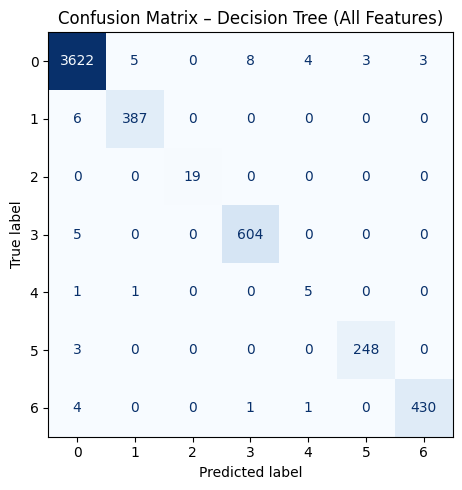

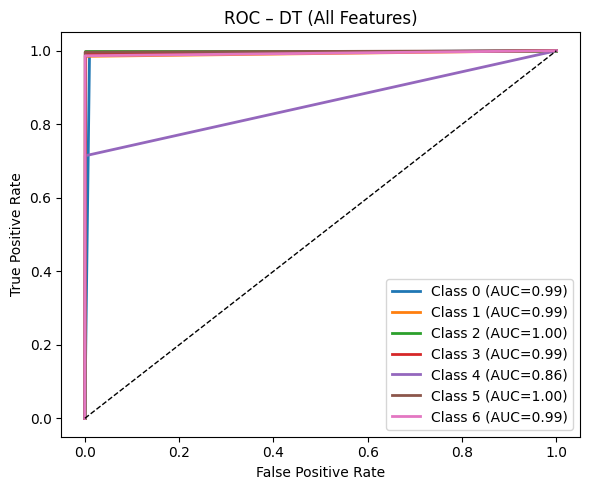


=== XGBoost (All Features) ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3645
           1       0.99      0.99      0.99       393
           2       1.00      1.00      1.00        19
           3       1.00      1.00      1.00       609
           4       1.00      0.86      0.92         7
           5       0.99      1.00      0.99       251
           6       1.00      0.99      1.00       436

    accuracy                           1.00      5360
   macro avg       1.00      0.98      0.99      5360
weighted avg       1.00      1.00      1.00      5360

{'Accuracy': 0.9970149253731343, 'Precision': 0.9970211798159752, 'Recall': 0.9970149253731343, 'F1': 0.9970090488599049, 'AUC': 0.9997897477441822}


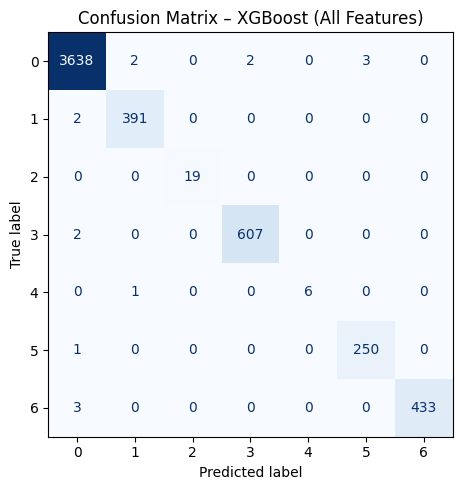

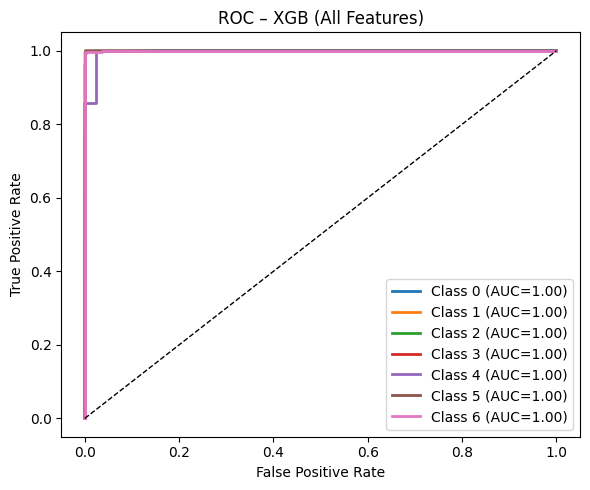


=== Extra Trees (All Features) ===
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3645
           1       0.93      0.98      0.95       393
           2       1.00      0.89      0.94        19
           3       0.99      0.98      0.98       609
           4       1.00      0.86      0.92         7
           5       0.99      0.99      0.99       251
           6       0.99      0.97      0.98       436

    accuracy                           0.98      5360
   macro avg       0.98      0.95      0.97      5360
weighted avg       0.98      0.98      0.98      5360

{'Accuracy': 0.983955223880597, 'Precision': 0.984217173566775, 'Recall': 0.983955223880597, 'F1': 0.9840019350829723, 'AUC': 0.9985240821808514}


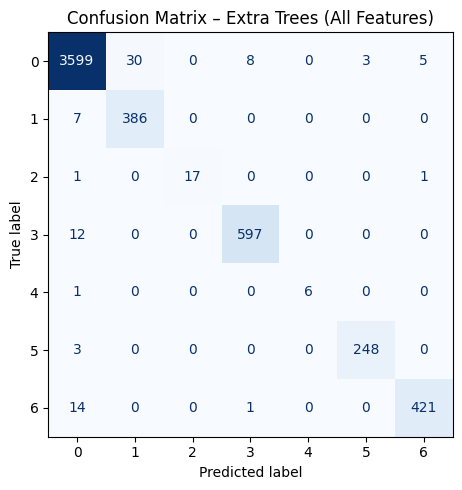

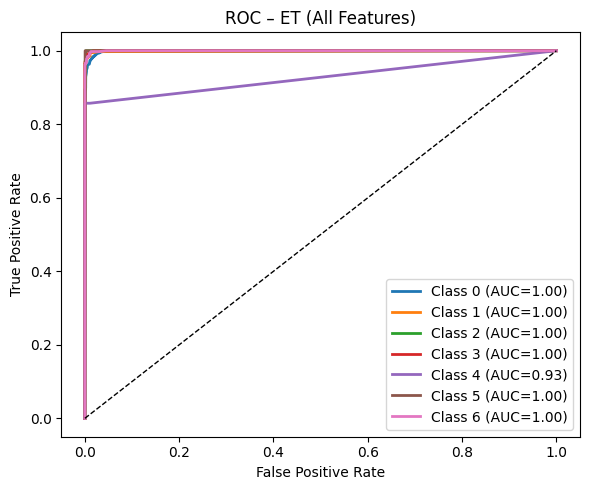

In [ ]:
# ----------------------------
# BASELINE: DT, XGB, ET (ALL FEATURES)
# ----------------------------
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from xgboost import XGBClassifier

# Decision Tree
dt_base = DecisionTreeClassifier(random_state=RANDOM_SEED)
dt_base.fit(X_train, y_train)
dt_base_res = eval_metrics(dt_base, X_train, y_train, X_test, y_test, 
                           model_name="Decision Tree (All Features)", plot_cm=True)
plot_roc_curves(dt_base, X_test, y_test, title="ROC – DT (All Features)")

# XGBoost
xgb_base = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=RANDOM_SEED)
xgb_base.fit(X_train, y_train)
xgb_base_res = eval_metrics(xgb_base, X_train, y_train, X_test, y_test, 
                            model_name="XGBoost (All Features)", plot_cm=True)
plot_roc_curves(xgb_base, X_test, y_test, title="ROC – XGB (All Features)")

# Extra Trees
et_base = ExtraTreesClassifier(n_estimators=100, random_state=RANDOM_SEED)
et_base.fit(X_train, y_train)
et_base_res = eval_metrics(et_base, X_train, y_train, X_test, y_test, 
                           model_name="Extra Trees (All Features)", plot_cm=True)
plot_roc_curves(et_base, X_test, y_test, title="ROC – ET (All Features)")



=== Decision Tree + MBGWO ===
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      3645
           1       0.99      0.99      0.99       393
           2       1.00      0.95      0.97        19
           3       0.98      1.00      0.99       609
           4       1.00      0.86      0.92         7
           5       0.98      1.00      0.99       251
           6       0.98      0.99      0.98       436

    accuracy                           0.99      5360
   macro avg       0.99      0.97      0.98      5360
weighted avg       0.99      0.99      0.99      5360

{'Accuracy': 0.9923507462686567, 'Precision': 0.9923948945654344, 'Recall': 0.9923507462686567, 'F1': 0.9923520577245635, 'AUC': 0.9939704392470966}


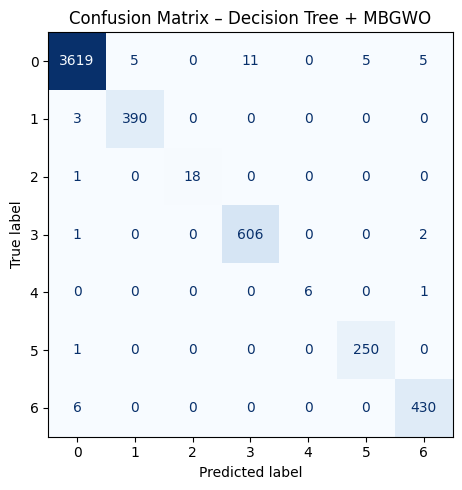

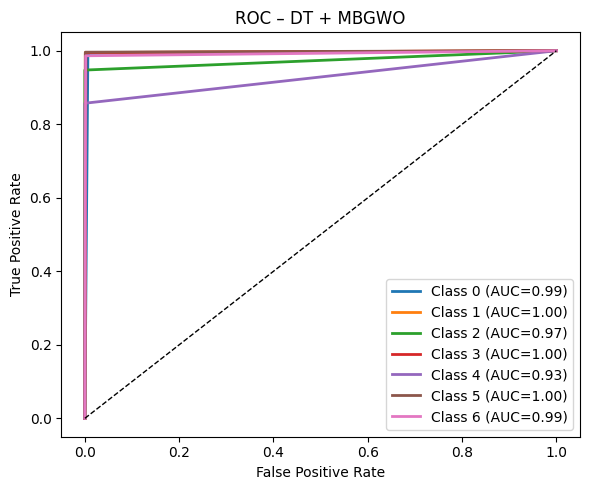


=== XGBoost + MBGWO ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3645
           1       1.00      0.99      1.00       393
           2       1.00      1.00      1.00        19
           3       1.00      1.00      1.00       609
           4       1.00      0.86      0.92         7
           5       0.98      1.00      0.99       251
           6       1.00      0.99      0.99       436

    accuracy                           1.00      5360
   macro avg       1.00      0.98      0.98      5360
weighted avg       1.00      1.00      1.00      5360

{'Accuracy': 0.9960820895522388, 'Precision': 0.9960946234703152, 'Recall': 0.9960820895522388, 'F1': 0.996076154581592, 'AUC': 0.9996054234502699}


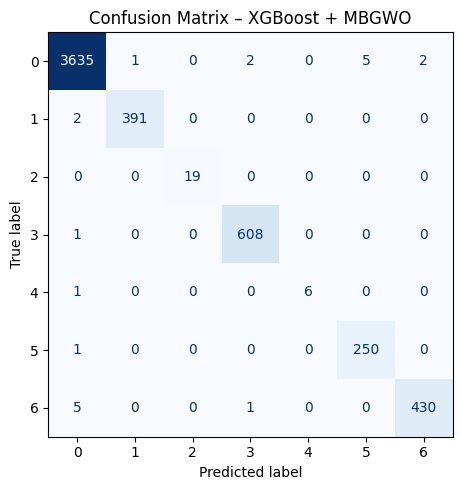

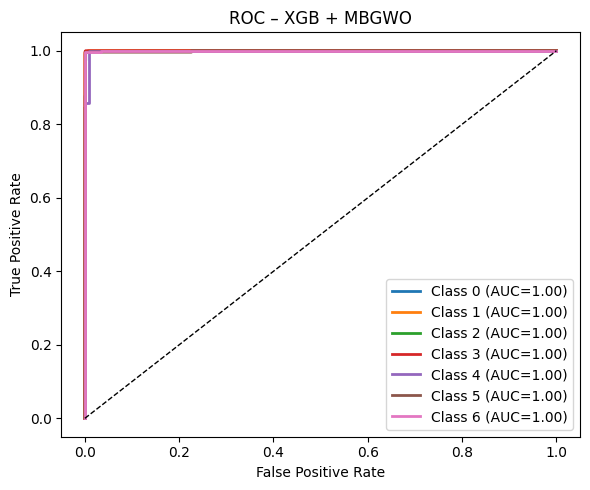


=== Extra Trees + MBGWO ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3645
           1       0.99      0.99      0.99       393
           2       1.00      1.00      1.00        19
           3       1.00      1.00      1.00       609
           4       1.00      0.86      0.92         7
           5       0.98      1.00      0.99       251
           6       1.00      0.98      0.99       436

    accuracy                           1.00      5360
   macro avg       1.00      0.97      0.98      5360
weighted avg       1.00      1.00      1.00      5360

{'Accuracy': 0.9955223880597015, 'Precision': 0.9955324906928414, 'Recall': 0.9955223880597015, 'F1': 0.9955130469788634, 'AUC': 0.9989207694928245}


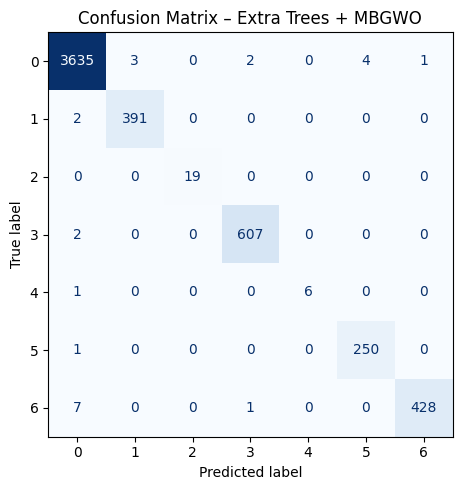

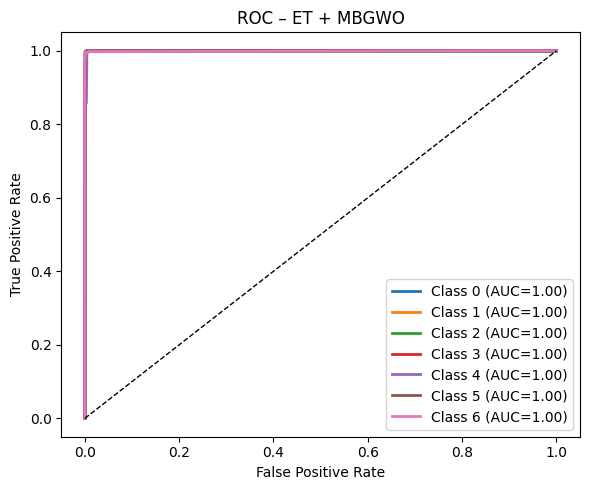

In [ ]:
# ----------------------------
# MODELS AFTER MBGWO
# ----------------------------

# Decision Tree + MBGWO
dt_mbgwo = DecisionTreeClassifier(random_state=RANDOM_SEED)
dt_mbgwo.fit(X_train_sel, y_train)
dt_mbgwo_res = eval_metrics(dt_mbgwo, X_train_sel, y_train, X_test_sel, y_test, 
                            model_name="Decision Tree + MBGWO", plot_cm=True)
plot_roc_curves(dt_mbgwo, X_test_sel, y_test, title="ROC – DT + MBGWO")

# XGBoost + MBGWO
xgb_mbgwo = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=RANDOM_SEED)
xgb_mbgwo.fit(X_train_sel, y_train)
xgb_mbgwo_res = eval_metrics(xgb_mbgwo, X_train_sel, y_train, X_test_sel, y_test, 
                             model_name="XGBoost + MBGWO", plot_cm=True)
plot_roc_curves(xgb_mbgwo, X_test_sel, y_test, title="ROC – XGB + MBGWO")

# Extra Trees + MBGWO
et_mbgwo = ExtraTreesClassifier(n_estimators=100, random_state=RANDOM_SEED)
et_mbgwo.fit(X_train_sel, y_train)
et_mbgwo_res = eval_metrics(et_mbgwo, X_train_sel, y_train, X_test_sel, y_test, 
                            model_name="Extra Trees + MBGWO", plot_cm=True)
plot_roc_curves(et_mbgwo, X_test_sel, y_test, title="ROC – ET + MBGWO")


In [ ]:
# ----------------------------
# FINAL COMPARISON TABLE FOR ALL MODELS
# ----------------------------
comparison = pd.DataFrame([
    {"Model": "Random Forest (All Features)", **baseline_res},
    {"Model": "Random Forest + MBGWO", **mbgwo_res},
    {"Model": "Decision Tree (All Features)", **dt_base_res},
    {"Model": "Decision Tree + MBGWO", **dt_mbgwo_res},
    {"Model": "XGBoost (All Features)", **xgb_base_res},
    {"Model": "XGBoost + MBGWO", **xgb_mbgwo_res},
    {"Model": "Extra Trees (All Features)", **et_base_res},
    {"Model": "Extra Trees + MBGWO", **et_mbgwo_res}
  
])

print("\n=== Final Comparison Table ===")
print(comparison) 



=== Final Comparison Table ===
                          Model  Accuracy  Precision    Recall        F1  \
0  Random Forest (All Features)  0.991604   0.991631  0.991604  0.991585   
1         Random Forest + MBGWO  0.995709   0.995718  0.995709  0.995699   
2  Decision Tree (All Features)  0.991604   0.991888  0.991604  0.991719   
3         Decision Tree + MBGWO  0.992351   0.992395  0.992351  0.992352   
4        XGBoost (All Features)  0.997015   0.997021  0.997015  0.997009   
5               XGBoost + MBGWO  0.996082   0.996095  0.996082  0.996076   
6    Extra Trees (All Features)  0.983955   0.984217  0.983955  0.984002   
7           Extra Trees + MBGWO  0.995522   0.995532  0.995522  0.995513   

        AUC                                             y_pred  
0  0.999198  [3, 0, 3, 6, 6, 0, 1, 0, 0, 1, 3, 0, 0, 0, 0, ...  
1  0.999343  [3, 0, 3, 6, 6, 0, 1, 0, 0, 1, 3, 0, 0, 0, 0, ...  
2  0.992412  [3, 0, 3, 6, 6, 0, 1, 0, 0, 1, 3, 0, 0, 0, 0, ...  
3  0.993970  [3, 0, 3, 

## 📌 Conclusion

This notebook demonstrated the application of the Modified Binary Grey Wolf Optimizer (MBGWO) for feature selection in the domain of intrusion detection using the sampled CICIDS2017 dataset.

Key outcomes from this study:

- **MBGWO effectively reduced the number of features** while preserving high classification performance across all models.
- **XGBoost (All Features)** delivered the best accuracy overall (99.70%), highlighting its strength even without feature reduction.
- **MBGWO + XGBoost and MBGWO + Random Forest** both achieved near-optimal performance, proving that MBGWO-selected features retained the most discriminative information.
- **Simpler models like Decision Tree and Extra Trees also improved** significantly after MBGWO, validating the optimizer's generalizability.
- Evaluation metrics (Accuracy, Precision, Recall, F1-score, and AUC) consistently confirmed the robustness of the MBGWO-based selection across classifiers.

This study confirms that combining intelligent metaheuristic-based feature selection (MBGWO) with well-established classifiers like Random Forest and XGBoost leads to a more efficient and scalable IDS, with reduced computational load and improved generalization. Future work could extend this framework using deep learning classifiers or test it on alternative cybersecurity datasets.
